# HDR gathering
Like basic gather, but with multiple pictures taken at different attenuations.

## Setup
Run `python f_camera_photonics\tcp_link.py` on the lab computer. Only one thing can use the analog port at a time, so make sure it is grabbing from the digital only.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import cv2
import sys, os
import numpy as np
import pickle
import matplotlib.pyplot as plt

sys.path.append('..')
# import f_camera_photonics
from f_camera_photonics.component_capture import single_shot
from f_camera_photonics import cvshow
from f_camera_photonics.peak_finder import f_camera_photonics, main, get_all_config, PortArray
from f_camera_photonics.tcp_link import remote_call, capture, attenuate, unpack_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [211]:
remote = True
datadir = '../measurement_data/chicken-cutbacks-round2'

sample_name = 'x8-y4'  # change this every device
def to_file(extension):
    return os.path.join(datadir, sample_name + extension)

In [212]:
def save_matrix(HDR, Powers):
    pickle.dump(Powers, open(to_file('.pickle'), 'wb'))
    
    metadata = dict(HDR_vals=list(HDR),
                    laser_Amps=0.130)  # this second row you fill out manually
    pickle.dump(metadata, open(to_file('.metadata.pickle'), 'wb'))
    
    fi, ax = plt.subplots(figsize=(10, 5))
    ax.loglog(10 ** (-HDR / 10), Powers, '.-')
    ax.grid(which='minor')
    plt.xlabel('Attenuation')
    plt.ylabel('Port power')
    plt.title(sample_name)
    plt.savefig(to_file('.png'))

## Preview valid box
You can do this with the lamp on, but make sure to turn it off afterward.

You will be given a preview of the valid box

In [213]:
if remote:
    remote_call(attenuate, atten=12)
    img = unpack_image(remote_call(capture, avgcnt=2))
else:
    atten_db(atten=10)
    img = single_shot()
    
cfg=get_all_config()
if cfg.valid_box is not None:
    x, y, w, h = cfg.valid_box
#     cv2.rectangle(img, (x, y), (x+w, y+h), (0,0,255), 2)
    
cv2.imwrite(to_file('.tif'), img)
# cv2.imwrite(os.path.join(datadir, 'typical-00dB-bright.tif'), img)  # various pictures you want to save otherwise

# cvshow(img)

/Users/ant12/Documents/git-projects/experiment-code/camera_photonics/f_camera_photonics/config.ini


True

### If you are satisfied with the valid box, turn out the lamp and move on

## Find the port box spec on the saved image
You will be given a preview of the port boxes

In [214]:
# No file artifacts
# pout = f_camera_photonics(filename=tif_file, box_spec=None, max_box_width=10)
# port_arr = PortArray.from_dict(pout)

if False:  # Use the manual box spec or not
    # This is set up so you put the center spot right next to the line of dead pixels
    all_y = 445
    xlist = np.linspace(38, 433, 16)
    my_boxspec = [[x, all_y, 10] for x in xlist]
else:
    my_boxspec = None


# File artifacts
main(filename=to_file('.tif'), box_spec=my_boxspec, box_width=15)
with open(to_file('.json'), 'r') as fx:
    port_arr = PortArray.from_dict(json.load(fx))
port_arr.sort_by('position')
    
print(port_arr)

/Users/ant12/Documents/git-projects/experiment-code/camera_photonics/f_camera_photonics/config.ini
The maximum value in the image after darkfield correction is: 246.0 (out of a camera limit of 4095.0)


/Users/ant12/Documents/git-projects/experiment-code/camera_photonics/f_camera_photonics/peak_finder.py:356: RuntimeWarning: divide by zero encountered in log10
  img_8bit = np.array(img_8bit, dtype = np.uint8)


(#1, P: 1.00)
(#2, P: 1.00)
Check if it is correct
Press any key to close the display window
Saving to x8-y4.json in ../measurement_data/chicken-cutbacks-round2
[array([2.96000e+02, 2.62000e+02, 1.50000e+01, 1.12173e+05]), array([3.26000e+02, 2.60000e+02, 1.50000e+01, 1.12227e+05])]


### If you are satisfied with port boxes, move on

## HDR image taking

In [215]:
HDR_vals = np.linspace(0, 40, 30)
P_matrix = np.ones((len(HDR_vals), len(port_arr)))
for i, db in enumerate(HDR_vals):
    if remote:
        remote_call(attenuate, atten=db)
        img = unpack_image(remote_call(capture, avgcnt=2))
    else:
        atten_db(db)
        img = single_shot()
    print('i =', i)
    P_matrix[i, :] = port_arr.calc_powers(img, use_max=True)
remote_call(attenuate, atten=17)  # reset

i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i = 27
i = 28
i = 29


17

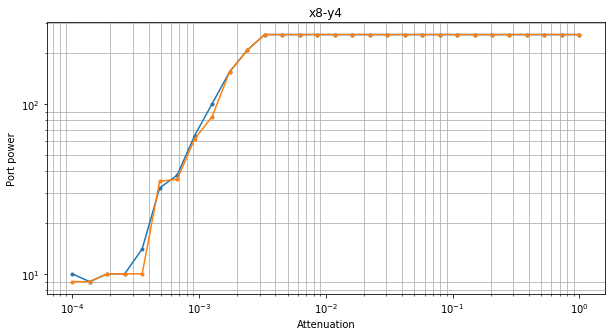

In [216]:
# if you like it save it
save_matrix(HDR_vals, P_matrix)

In [ ]:
plt.loglog(10 ** (-HDR_vals / 10), P_matrix[:, ::2]-np.min(P_matrix)+1e2, '.-')